# Tensorflow Object Detection API and AWS Sagemaker

In this notebook, you will train and evaluate different models using the [Tensorflow Object Detection API](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/) and [AWS Sagemaker](https://aws.amazon.com/sagemaker/). 

If you ever feel stuck, you can refer to this [tutorial](https://aws.amazon.com/blogs/machine-learning/training-and-deploying-models-using-tensorflow-2-with-the-object-detection-api-on-amazon-sagemaker/).

## Dataset

We are using the [Waymo Open Dataset](https://waymo.com/open/) for this project. The dataset has already been exported using the tfrecords format. The files have been created following the format described [here](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#create-tensorflow-records). You can find data stored on [AWS S3](https://aws.amazon.com/s3/), AWS Object Storage. The images are saved with a resolution of 640x640.

In [2]:
%%capture
%pip install tensorflow_io sagemaker -U

In [3]:
import os
import sagemaker
from sagemaker.estimator import Estimator
from framework import CustomFramework

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Save the IAM role in a variable called `role`. This would be useful when training the model.

In [4]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::756583782187:role/service-role/AmazonSageMaker-ExecutionRole-20240718T215661


In [5]:
# The train and val paths below are public S3 buckets created by Udacity for this project
inputs = {'train': 's3://cd2688-object-detection-tf2/train/', 
          'val': 's3://cd2688-object-detection-tf2/val/'} 

# Insert path of a folder in your personal S3 bucket to store tensorboard logs.
tensorboard_s3_prefix = 's3://udacity-sdc-proj1-s3/logs/'

## Container

To train the model, you will first need to build a [docker](https://www.docker.com/) container with all the dependencies required by the TF Object Detection API. The code below does the following:
* clone the Tensorflow models repository
* get the exporter and training scripts from the repository
* build the docker image and push it 
* print the container name

In [6]:
%%bash

# clone the repo and get the scripts
git clone https://github.com/tensorflow/models.git docker/models

# get model_main and exporter_main files from TF2 Object Detection GitHub repository
cp docker/models/research/object_detection/exporter_main_v2.py source_dir 
cp docker/models/research/object_detection/model_main_tf2.py source_dir

fatal: destination path 'docker/models' already exists and is not an empty directory.


In [ ]:
# build and push the docker image. This code can be commented out after being run once.
# This will take around 10 mins.
# image_name = 'tf2-object-detection'
# !sh ./docker/build_and_push.sh $image_name

To verify that the image was correctly pushed to the [Elastic Container Registry](https://aws.amazon.com/ecr/), you can look at it in the AWS webapp. For example, below you can see that three different images have been pushed to ECR. You should only see one, called `tf2-object-detection`.
![ECR Example](../data/example_ecr.png)


In [7]:
# display the container name
with open (os.path.join('docker', 'ecr_image_fullname.txt'), 'r') as f:
    container = f.readlines()[0][:-1]

print(container)

756583782187.dkr.ecr.us-east-1.amazonaws.com/tf2-object-detection:20240719000143


## Pre-trained model from model zoo

As often, we are not training from scratch and we will be using a pretrained model from the TF Object Detection model zoo. You can find pretrained checkpoints [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Because your time is limited for this project, we recommend to only experiment with the following models:
* SSD MobileNet V2 FPNLite 640x640	
* SSD ResNet50 V1 FPN 640x640 (RetinaNet50)	
* Faster R-CNN ResNet50 V1 640x640	
* EfficientDet D1 640x640	
* Faster R-CNN ResNet152 V1 640x640	

In the code below, the EfficientDet D1 model is downloaded and extracted. This code should be adjusted if you were to experiment with other architectures.

In [ ]:
%%bash
mkdir /tmp/checkpoint
mkdir source_dir/checkpoint

# EfficientDet
# wget -O /tmp/efficientdet.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz
# tar -zxvf /tmp/efficientdet.tar.gz --strip-components 2 --directory source_dir/checkpoint efficientdet_d1_coco17_tpu-32/checkpoint

# SSD ResNet50 V1 FPN 640x640 (RetinaNet50)
# wget -O /tmp/ssd_resnet.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# tar -zxvf /tmp/ssd_resnet.tar.gz --strip-components 2 --directory source_dir/checkpoint ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint

# SSD MobileNet V2 FPNLite 640x640
# wget -O /tmp/ssd_mobilenet.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
# tar -zxvf /tmp/ssd_mobilenet.tar.gz --strip-components 2 --directory source_dir/checkpoint ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint

## Edit pipeline.config file

The [`pipeline.config`](source_dir/pipeline.config) in the `source_dir` folder should be updated when you experiment with different models. The different config files are available [here](https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2).

>Note: The provided `pipeline.config` file works well with the `EfficientDet` model. You would need to modify it when working with other models.

## Launch Training Job

Now that we have a dataset, a docker image and some pretrained model weights, we can launch the training job. To do so, we create a [Sagemaker Framework](https://sagemaker.readthedocs.io/en/stable/frameworks/index.html), where we indicate the container name, name of the config file, number of training steps etc.

The `run_training.sh` script does the following:
* train the model for `num_train_steps` 
* evaluate over the val dataset
* export the model

Different metrics will be displayed during the evaluation phase, including the mean average precision. These metrics can be used to quantify your model performances and compare over the different iterations.

You can also monitor the training progress by navigating to **Training -> Training Jobs** from the Amazon Sagemaker dashboard in the Web UI.

In [9]:
tensorboard_output_config = sagemaker.debugger.TensorBoardOutputConfig(
    s3_output_path=tensorboard_s3_prefix,
    container_local_output_path='/opt/training/'
)

estimator = CustomFramework(
    role=role,
    image_uri=container,
    entry_point='run_training.sh',
    source_dir='source_dir/',
    hyperparameters={
        "model_dir": "/opt/training",        
        "pipeline_config_path": "ssd_mobilenet.config",
        "num_train_steps": "2000",    
        "sample_1_of_n_eval_examples": "1"
    },
    instance_count=1,
    instance_type='ml.g5.4xlarge',
    tensorboard_output_config=tensorboard_output_config,
    disable_profiler=True,
    base_job_name='tf2-object-detection'
)

estimator.fit(inputs)

INFO:sagemaker:Creating training-job with name: tf2-object-detection-2024-07-19-05-06-53-324


2024-07-19 05:06:54 Starting - Starting the training job...
2024-07-19 05:07:12 Starting - Preparing the instances for training...
2024-07-19 05:07:47 Downloading - Downloading input data...
2024-07-19 05:08:02 Downloading - Downloading the training image...............
2024-07-19 05:10:29 Training - Training image download completed. Training in progress...2024-07-19 05:10:57,523 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-07-19 05:10:57,561 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-07-19 05:10:57,598 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-07-19 05:10:57,615 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train",
        "val": "/opt/ml/input/data/val"
    },
    "current_host": "algo-1",
    "curren

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0719 05:11:10.522082 139851760396096 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use `tf.cast` instead.
W0719 05:11:14.068253 139851760396096 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
/usr/local/lib/python3.8/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/Fa

INFO:tensorflow:Step 400 per-step time 0.223s
I0719 05:13:34.556737 139851760396096 model_lib_v2.py:705] Step 400 per-step time 0.223s
INFO:tensorflow:{'Loss/classification_loss': 0.29005516,
 'Loss/localization_loss': 0.52753174,
 'Loss/regularization_loss': 0.1513416,
 'Loss/total_loss': 0.9689285,
 'learning_rate': 0.0136400005}
I0719 05:13:34.556956 139851760396096 model_lib_v2.py:708] {'Loss/classification_loss': 0.29005516,
 'Loss/localization_loss': 0.52753174,
 'Loss/regularization_loss': 0.1513416,
 'Loss/total_loss': 0.9689285,
 'learning_rate': 0.0136400005}
INFO:tensorflow:Step 500 per-step time 0.223s
I0719 05:13:56.826862 139851760396096 model_lib_v2.py:705] Step 500 per-step time 0.223s
INFO:tensorflow:{'Loss/classification_loss': 0.31885892,
 'Loss/localization_loss': 0.5086268,
 'Loss/regularization_loss': 0.15134433,
 'Loss/total_loss': 0.9788301,
 'learning_rate': 0.016800001}
I0719 05:13:56.827100 139851760396096 model_lib_v2.py:708] {'Loss/classification_loss': 0.3

INFO:tensorflow:Step 1800 per-step time 0.223s
I0719 05:18:47.122376 139851760396096 model_lib_v2.py:705] Step 1800 per-step time 0.223s
INFO:tensorflow:{'Loss/classification_loss': 0.2615692,
 'Loss/localization_loss': 0.35511744,
 'Loss/regularization_loss': 0.15159589,
 'Loss/total_loss': 0.76828253,
 'learning_rate': 0.05788}
I0719 05:18:47.122612 139851760396096 model_lib_v2.py:708] {'Loss/classification_loss': 0.2615692,
 'Loss/localization_loss': 0.35511744,
 'Loss/regularization_loss': 0.15159589,
 'Loss/total_loss': 0.76828253,
 'learning_rate': 0.05788}
INFO:tensorflow:Step 1900 per-step time 0.223s
I0719 05:19:09.399389 139851760396096 model_lib_v2.py:705] Step 1900 per-step time 0.223s
INFO:tensorflow:{'Loss/classification_loss': 0.24421622,
 'Loss/localization_loss': 0.3470237,
 'Loss/regularization_loss': 0.1516511,
 'Loss/total_loss': 0.742891,
 'learning_rate': 0.06104}
I0719 05:19:09.399620 139851760396096 model_lib_v2.py:708] {'Loss/classification_loss': 0.24421622,
 

INFO:tensorflow:Finished eval step 100
I0719 05:20:11.851079 139664474478400 model_lib_v2.py:966] Finished eval step 100
INFO:tensorflow:Finished eval step 200
I0719 05:20:15.747887 139664474478400 model_lib_v2.py:966] Finished eval step 200
INFO:tensorflow:Performing evaluation on 258 images.
I0719 05:20:17.987877 139664474478400 coco_evaluation.py:293] Performing evaluation on 258 images.
INFO:tensorflow:Loading and preparing annotation results...
I0719 05:20:17.992127 139664474478400 coco_tools.py:116] Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.01s)
I0719 05:20:18.006162 139664474478400 coco_tools.py:138] DONE (t=0.01s)
INFO:tensorflow:Eval metrics at step 2000
I0719 05:20:27.380183 139664474478400 model_lib_v2.py:1015] Eval metrics at step 2000
INFO:tensorflow:#011+ DetectionBoxes_Precision/mAP: 0.068614
I0719 05:20:27.427024 139664474478400 model_lib_v2.py:1018] #011+ DetectionBoxes_Precision/mAP: 0.068614
INFO:tensorflow:#011+ DetectionBoxes_Precision/m

I0719 05:25:24.965398 140207644960576 save.py:274] Found untraced functions such as WeightSharedConvolutionalBoxPredictor_layer_call_fn, WeightSharedConvolutionalBoxPredictor_layer_call_and_return_conditional_losses, WeightSharedConvolutionalBoxHead_layer_call_fn, WeightSharedConvolutionalBoxHead_layer_call_and_return_conditional_losses, WeightSharedConvolutionalClassHead_layer_call_fn while saving (showing 5 of 173). These functions will not be directly callable after loading.

2024-07-19 05:25:37 Uploading - Uploading generated training modelINFO:tensorflow:Assets written to: /tmp/exported/saved_model/assets
I0719 05:25:30.071724 140207644960576 builder_impl.py:804] Assets written to: /tmp/exported/saved_model/assets
I0719 05:25:30.420825 140207644960576 fingerprinting_utils.py:48] Writing fingerprint to /tmp/exported/saved_model/fingerprint.pb
INFO:tensorflow:Writing pipeline config file to /tmp/exported/pipeline.config
I0719 05:25:30.831625 140207644960576 config_util.py:253] Writi

## Improve on the initial model

Most likely, this initial experiment did not yield optimal results. However, you can make multiple changes to the `pipeline.config` file to improve this model. One obvious change consists in improving the data augmentation strategy. The [`preprocessor.proto`](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto) file contains the different data augmentation method available in the Tf Object Detection API. Justify your choices of augmentations in the write-up.

Keep in mind that the following are also available:
* experiment with the optimizer: type of optimizer, learning rate, scheduler etc
* experiment with the architecture. The Tf Object Detection API model zoo offers many architectures. Keep in mind that the pipeline.config file is unique for each architecture and you will have to edit it.
* visualize results on the test frames using the `2_deploy_model` notebook available in this repository.

In the cell below, write down all the different approaches you have experimented with, why you have chosen them and what you would have done if you had more time and resources. Justify your choices using the tensorboard visualizations (take screenshots and insert them in your write-up), the metrics on the evaluation set and the generated animation you have created with [this tool](../2_run_inference/2_deploy_model.ipynb).

# I. Model evaluation

Within the scope of this project, I have conducted training on 3 pre-trained models: `EfficientDet`, `SSD Resnet` and `SSD MobileNet`. All the 3 models share the same training and validation configs:

- Training configs:
    + Training steps: 2000
    + Batch size: 8
    + Data augmentation method: random horizontal flip & random scale cropping and padding to square
    + Optimizer: momentum optimizer
- Evaluation configs:
    + Metric: COCO detection
    + Batch size: 1
- Notebook computation instance type: `ml.g5.4xlarge`

Each model yields different results, as shown below.

## 1. EfficientDet

(orange stands for training, blue stands for validation)

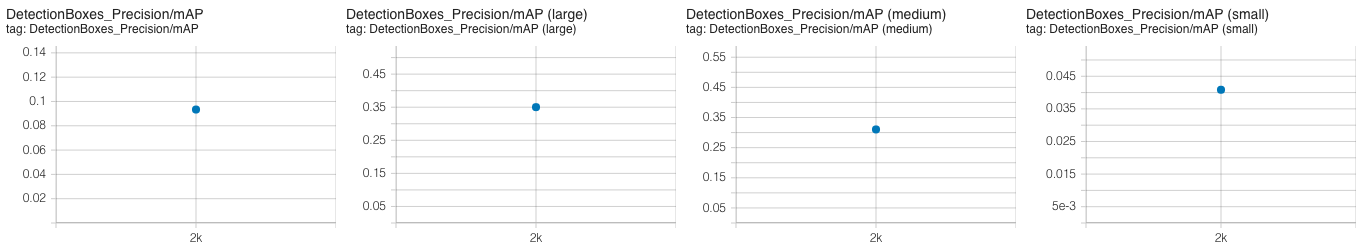

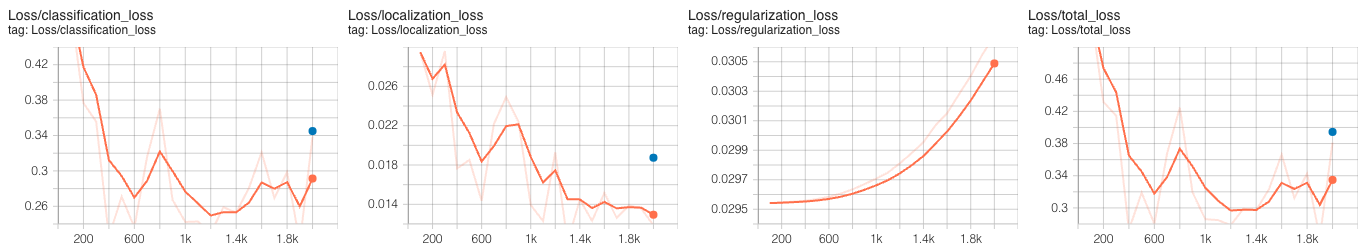

## 2. SSD Resnet

(brown stands for training, light blue stands for validation)

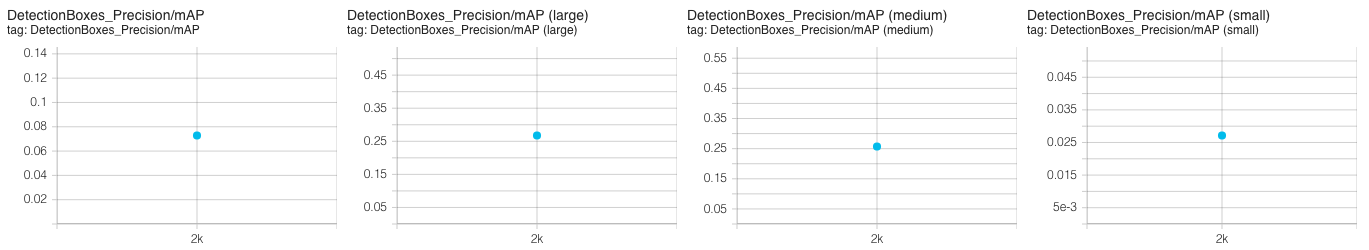

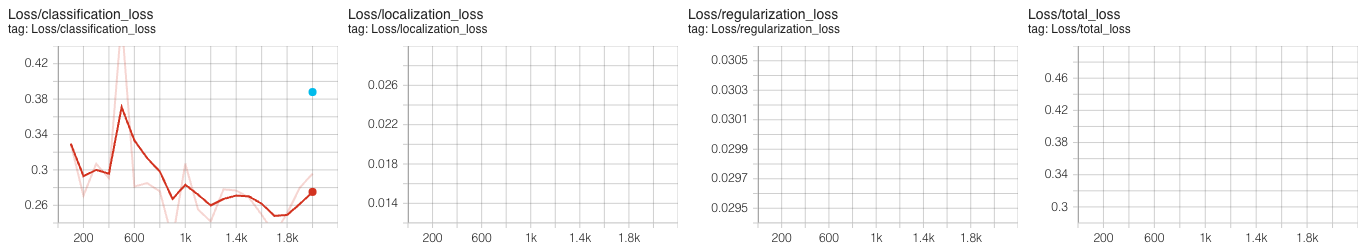

(dunno why there is only classification loss)

## 3. SSD MobileNet

(pink stands for training, green stands for validation)

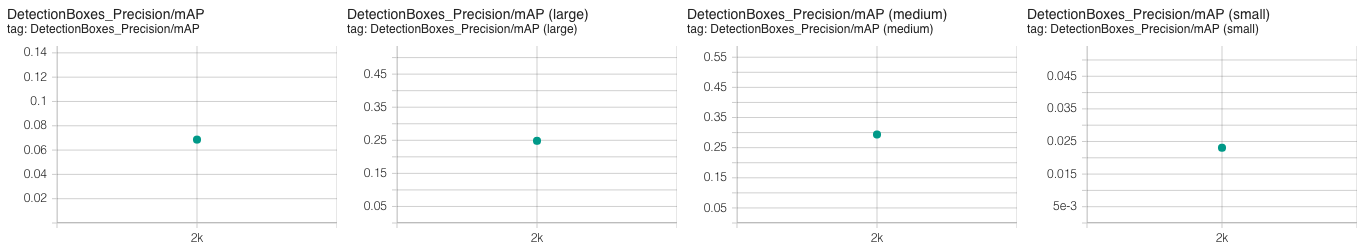

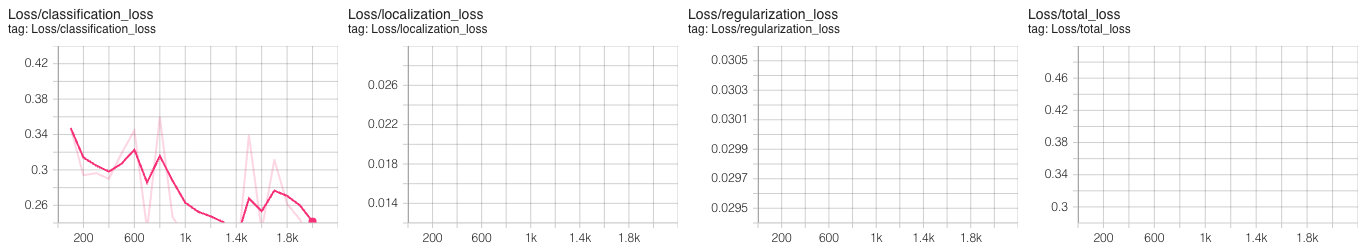

(also dunno why there is only classification loss)

## 4. Model comparison

(dark blue stands for EfficientDet, light blue stands for Resnet, and green stands for MobileNet)

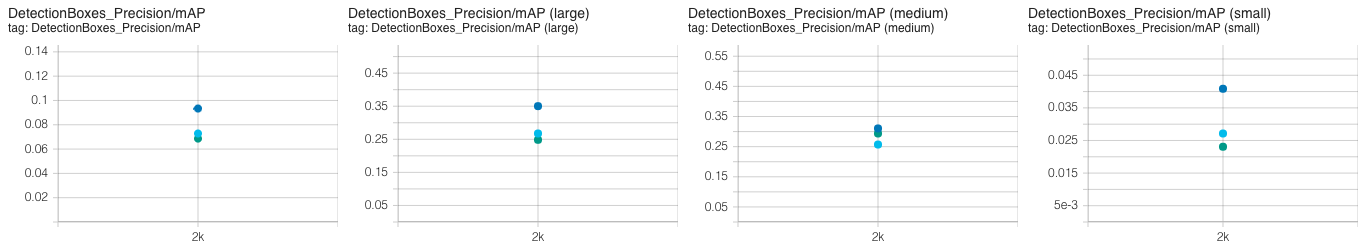

As you can see, although the 3 models yield quite shitty mAP values, still, EfficientDet performs better than other 2. This is also reflected in the original [TF Object Detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) where `EfficientDet D1` with COCO mAP of `38.4` outperforms `SSD Resnet` and `SSD MobileNet` with COCO mAP of `34.3` and `29.1` respectively.

Thus, I choose **EfficientDet** as my model to proceed to step 2.

Also, validation loss in all 3 cases seem to be higher than training loss, possibly due to overfitting, since we also observed training loss with all cases seem to re-surge during the latter half of the training. To deal with this, we can implement early stopping methods (ideally when the loss starts re-surging), regularization, etc.

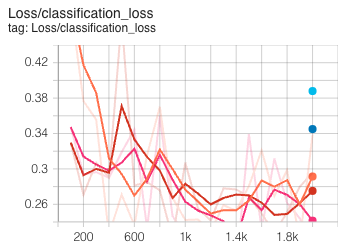

# II. Model deployment and result

After deploying the best model chosen above with notebook `2_deploy_model.ipynb`, the result video is generated, and can be seen in `../2_run_inference/output.avi`.